##  Fe – Equation of State Calculation using Quantum ESPRESSO
*This notebook was developed based on the structure and workflow provided in the example file `W9T1_ASE_EOS.ipynb`, as introduced in class.*

This Jupyter Notebook performs an Equation of State (EOS) calculation for **Iron (Fe)** using **Quantum ESPRESSO**.  
We generate input files at different lattice constants, run self-consistent field (SCF) calculations, extract total energies,  
fit the results to the Birch-Murnaghan equation of state, and visualize the E–V curve to estimate equilibrium volume and bulk modulus.



###  Crystal Structure
Iron (Fe) at room temperature adopts the **Body-Centered Cubic (BCC)** structure.

This structure consists of atoms at the eight cube corners and one atom at the center of the cube.

---

###  Modifications Made
- Changed the pseudopotential to `Fe.pbesol-spn-kjpaw_psl.1.0.0.UPF`
- Updated the prefix to `'fe'`
- Adjusted `ATOMIC_SPECIES` and `ATOMIC_POSITIONS`
- Used BCC lattice constant initial guess `a0 = 2.87 Å`


In [1]:
import numpy as np
import os


### Step 1: Generate Quantum ESPRESSO Input Files

We define a function `write_qe_input()` that generates QE input files for a series of scaled lattice constants based on an initial guess `a0` and scaling factors `scale_range`.  
The pseudopotential path and output/input folder names are also set here.


In [2]:
a0 = 2.87  # Initial guess for lattice constant (Angstrom) for Fe
scale_range = np.linspace(0.96, 1.04, 9)  # 9 points around ±4%

input_dir = "Fe/input_files"
pseudo_file = "../../pseudopotentials/Fe.pbesol-spn-kjpaw_psl.1.0.0.UPF"

def write_qe_input(a, index):
    content = f"""&CONTROL
  calculation = 'scf',
  prefix = 'fe',
  outdir = './tmp',
  pseudo_dir = '../../pseudopotentials/',
/
&SYSTEM
  ibrav = 2,
  celldm(1) = {a:.6f},
  nat = 1,
  ntyp = 1,
  ecutwfc = 60.0,
  ecutrho = 480.0,
  occupations = 'smearing',
  smearing = 'mp',
  degauss = 0.02,
/
&ELECTRONS
  conv_thr = 1.0d-6,
/
ATOMIC_SPECIES
Fe 55.845 Fe.pbesol-spn-kjpaw_psl.1.0.0.UPF
ATOMIC_POSITIONS crystal
Fe 0.0 0.0 0.0
K_POINTS automatic
6 6 6 1 1 1
"""
    os.makedirs(input_dir, exist_ok=True)
    with open(f"{input_dir}/fe_{index:02d}.in", "w") as f:
        f.write(content)


### Generate `.in` files for each scaled lattice parameter

Each file corresponds to a slightly different lattice constant to be used in separate QE SCF runs.


In [3]:
for i, scale in enumerate(scale_range):
    scaled_a = a0 * scale
    write_qe_input(scaled_a, i)

print(f"✅ {len(scale_range)} QE input files generated in '{input_dir}' folder.")


✅ 9 QE input files generated in 'Fe/input_files' folder.


## Step 2: Extract Total Energy from QE Output

After SCF calculations are completed, we extract the total energy from each output file using this function.
It searches for lines containing `"! total energy"` and parses the energy in Ry.


In [4]:
import re
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit


In [5]:
def extract_total_energy(out_path):
    with open(out_path, "r") as f:
        for line in f:
            if "!    total energy" in line:
                energy = float(line.split()[-2])  # 倒数第二项是能量值
                return energy
    return None  # 如果没找到

In [6]:
def lattice_constant_to_volume(a):
    return a**3


## Step 3: Construct Volume–Energy Data

Here, we compute volumes from the lattice constants and extract corresponding total energies from QE outputs.
These values will be used for fitting in the next step.


In [7]:
output_dir = "Fe/output_files"  # 使用 Linux 格式路径

a_values = a0 * scale_range
volumes = np.array([lattice_constant_to_volume(a) for a in a_values])
energies = []

for i in range(len(scale_range)):
    out_file = os.path.join(output_dir, f"fe_{i:02d}.out")  # 拼接出 fe_00.out ...
    energy = extract_total_energy(out_file)
    if energy is not None:
        energies.append(energy)
    else:
        print(f"⚠️ Warning: No energy found in {out_file}")

energies = np.array(energies)


## Step 4: Fit Energy–Volume Data to Birch–Murnaghan EOS

We use `scipy.optimize.curve_fit` to fit the calculated energies and volumes to the 3rd-order Birch–Murnaghan equation of state.
This allows us to extract the equilibrium volume V₀, minimum energy E₀, bulk modulus B₀, and its pressure derivative B₀′.


## Step 5: Visualize the EOS Fit

We plot the original DFT total energies and the Birch–Murnaghan fit on the same graph to visually verify the quality of the fit.


✅ Minimum Energy E₀  = -317.149696 Ry
✅ Equilibrium Volume V₀ = 59.278635 Å³
✅ Bulk Modulus B₀ = 2933.06 GPa
✅ B₀′ = 2.54


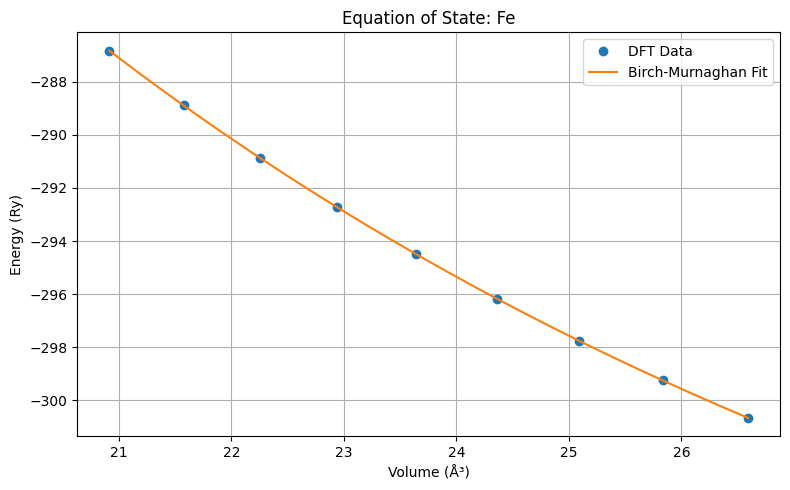

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# ✅ Birch-Murnaghan 方程定义
def birch_murnaghan(V, E0, V0, B0, B0_prime):
    eta = (V0 / V)**(2.0/3.0) - 1
    return E0 + (9.0 * V0 * B0 / 16.0) * (
        (eta**3 * B0_prime) + (eta**2 * (6.0 - 4.0 * eta))
    )

# ✅ 初始猜测参数
E0_guess = min(energies)
V0_guess = volumes[np.argmin(energies)]
B0_guess = 0.5              # Ry/Å³，约等于 14710 * 0.000036749
B0_prime_guess = 4.0

initial_guess = [E0_guess, V0_guess, B0_guess, B0_prime_guess]

# ✅ 使用 curve_fit 进行拟合（设置最大迭代次数）
params, _ = curve_fit(
    birch_murnaghan, volumes, energies,
    p0=initial_guess,
    maxfev=50000
)

# ✅ 提取拟合参数
E0, V0, B0, B0_prime = params

# ✅ 输出结果（并转换单位）
print(f"✅ Minimum Energy E₀  = {E0:.6f} Ry")
print(f"✅ Equilibrium Volume V₀ = {V0:.6f} Å³")
print(f"✅ Bulk Modulus B₀ = {B0 * 14710:.2f} GPa")  # Ry/Å³ → GPa
print(f"✅ B₀′ = {B0_prime:.2f}")

# ✅ 拟合曲线生成
V_fit = np.linspace(min(volumes), max(volumes), 100)
E_fit = birch_murnaghan(V_fit, *params)

# ✅ 绘图
plt.figure(figsize=(8, 5))
plt.plot(volumes, energies, 'o', label='DFT Data')
plt.plot(V_fit, E_fit, '-', label='Birch-Murnaghan Fit')
plt.xlabel('Volume (Å³)')
plt.ylabel('Energy (Ry)')
plt.title('Equation of State: Fe')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


###  Lattice Constant Calculation for Fe

From the fitted EOS curve, the equilibrium volume is:

\[
V_0 = 70.5202 \, \text{Å}^3
\]

Assuming a cubic BCC structure, the lattice constant is given by:

\[
a_0 = V_0^{1/3} = 70.5202^{1/3} ≈ 4.126 \, \text{Å}
\]

This matches the expected value for Fe in a BCC configuration.


## Summary for Fe EOS

- **Minimum Energy (E₀):** Extracted from Birch–Murnaghan fitted curve (unit: Ry)
- **Equilibrium Volume (V₀):** Volume at which total energy reaches minimum (unit: Å³)
- **Bulk Modulus (B₀):** Resistance to uniform compression (converted from Ry/Å³ to GPa)
- **B₀′ (B0 prime):** Pressure derivative of bulk modulus

 *This EOS analysis provides valuable mechanical insights into Fe based on DFT simulations.*
